In [4]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
DF_PATH = "./datasets/"
train = pd.read_csv(os.path.join(DF_PATH,'df_final.csv'))

In [7]:
train.head()
# target_dis: Hate presence
# 1: Hate
# 0: No hate

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_dis
0,530839,0.0,Oh really?,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,0
1,5748613,0.0,Off point as usual.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,3,4,0.0,4,4,0
2,578912,0.2,Ummm....I'm the one who gave you that citation...,0.0,0.0,0.0,0.2,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,5,1
3,5752481,0.2,"Uh-huh.\n\nI didn't say he used ""all caps"" for...",0.0,0.0,0.0,0.2,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,5,1
4,5335441,0.0,An exercise. Write your name backwards in cur...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,0


In [8]:
print("Dataframe shape: {}".format(train.shape))

Dataframe shape: (1080220, 46)


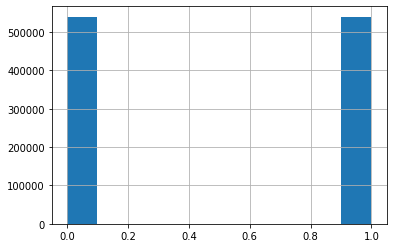

In [9]:
train.target_dis.hist()

## $Encoding$

##### Preprocess

In [11]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)
    return result

In [12]:
preprocessed_comments = train['comment_text'].sample(1080220).map(preprocess)

In [27]:
listToks = preprocessed_comments.values

In [28]:
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to \r reflect how important a word or n-gram is to a document in a collection or corpus. They provide some weighting to a given word based on the context it occurs.The tf–idf value increases proportionally to the number of times a word appears in a document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently than others.

However even though tf-idf BoW representations provide weights to different words they are unable to capture the word meaning.

In [29]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

## $C_{V}$, $C_{UMass}$

In [30]:
#Parametrical Sweep of n_topics and Compute Coherence Score
limit=15
c_v = [] # valores de coherencia 
u_mass = []
lm_list = []

for num_topics in range(1, limit):
  lm = LdaModel(corpus=corpus_tfidf, num_topics=num_topics, passes=5, iterations=50, id2word=dictionary)  
  lm_list.append(lm)
    
  cm_cv = CoherenceModel(model=lm, texts=listToks, coherence='c_v')
  c_v.append(cm_cv.get_coherence())
    
  cm_umass = CoherenceModel(model=lm, corpus=corpus_tfidf, coherence='u_mass')
  u_mass.append(cm_umass.get_coherence())

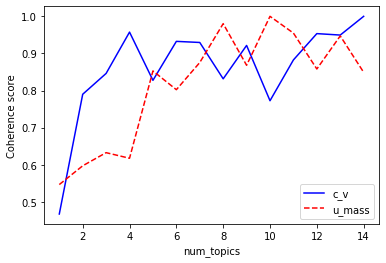

In [31]:
# Graphical Representation
u_mass_abs = list(map(abs, u_mass))
u_mass_max = max(u_mass_abs)
u_mass_esc = list(map(lambda x: x/u_mass_max, u_mass_abs))
c_v_abs =list(map(abs, c_v))
c_v_max = max(c_v_abs)
c_v_esc = list(map(lambda x: x/c_v_max, c_v_abs))
x = range(1, limit)

plt.plot(x, c_v_esc, 'b-', x, u_mass_esc, 'r--')
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v", "u_mass"), loc='best')
plt.show()



In [ ]:
import plotly
import plotly.graph_objects as go
import numpy as np

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(x), y=c_v_esc,
                    mode='lines+markers',
                    name=r'$C_v$'))
fig.add_trace(go.Scatter(x=list(x), y=u_mass_esc,
                    mode='lines+markers',
                    name=r'$C_{UMASS}$'))
# Edit the layout
fig.update_layout( xaxis_title=r'$\text{ Number of topics}$',
                   yaxis_title=r'$\text{ Coherence score}$')

fig.show()
#plotly.offline.plot(fig, 'coh_eval.html')

In [ ]:
import plotly
import plotly.graph_objects as go
import numpy as np

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(x), y=c_v_esc,
                    mode='lines+markers',
                    name='Cv'))
fig.add_trace(go.Scatter(x=list(x), y=u_mass_esc,
                    mode='lines+markers',
                    name='Umass'))
# Edit the layout
fig.update_layout( xaxis_title=' Number of topics',
                   yaxis_title=' Coherence score')

fig.show()
plotly.offline.plot(fig, 'coh_eval.html')

In [39]:
optimum_topics=4
lda_model=lm_list[optimum_topics-1]

In [41]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "LDAVis_train_4-topics.html")

In [42]:
optimum_topics=3
lda_model=lm_list[optimum_topics-1]

In [43]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "LDAVis_train_3-topics.html")

______________________________________________________________________________________________________________________

In [3]:
#Import
import re, os
import pandas as pd
from time import time
from collections import defaultdict

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import spacy

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M%S', level=logging.INFO)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
DF_PATH = "./datasets/"
train = pd.read_csv(os.path.join(DF_PATH,'df_final.csv'))

In [6]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_dis
0,530839,0.0,Oh really?,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,0
1,5748613,0.0,Off point as usual.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,3,4,0.0,4,4,0
2,578912,0.2,Ummm....I'm the one who gave you that citation...,0.0,0.0,0.0,0.2,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,5,1
3,5752481,0.2,"Uh-huh.\n\nI didn't say he used ""all caps"" for...",0.0,0.0,0.0,0.2,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,5,1
4,5335441,0.0,An exercise. Write your name backwards in cur...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,0


In [7]:
train.isnull().sum()

id                                          0
target                                      0
comment_text                                0
severe_toxicity                             0
obscene                                     0
identity_attack                             0
insult                                      0
threat                                      0
asian                                  815641
atheist                                815641
bisexual                               815641
black                                  815641
buddhist                               815641
christian                              815641
female                                 815641
heterosexual                           815641
hindu                                  815641
homosexual_gay_or_lesbian              815641
intellectual_or_learning_disability    815641
jewish                                 815641
latino                                 815641
male                              

### $Cleaning$
* $\text{We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.}$

In [ ]:
# Para instalar el paquete de idiomas 'en'
pip list
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [9]:
# disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt)>2:
        return ' '.join(txt)


In [10]:
brief_cleaning = (re.sub("[^A-Za-z']+",' ',str(row)).lower() for row in train['comment_text'])


In [11]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 37.79 mins


In [20]:
train_clean = pd.DataFrame({'clean': txt}) 

In [21]:
train_clean.shape

(1080220, 1)

In [22]:
train_clean.head(25)

,clean
0,None
1,None
2,ummm give citation tell r r mistaken nasty acc...
3,uh huh cap entire post say go e resort cap cle...
4,exercise write backwards cursive non dominant ...
5,bs need stop foreigner take away sovereignty y...
6,recall sixteen year ago fun stupid incompetent...
7,better send kali dog kennel pit area sure litt...
8,tweet know people tweet consider elite activity
9,american airlines cancel phoenix flight week p...


In [23]:
df_clean = train_clean
df_clean = df_clean.dropna().drop_duplicates()

In [25]:
df_clean.shape

(1026307, 1)

In [26]:
df_clean.head(25)

,clean
2,ummm give citation tell r r mistaken nasty acc...
3,uh huh cap entire post say go e resort cap cle...
4,exercise write backwards cursive non dominant ...
5,bs need stop foreigner take away sovereignty y...
6,recall sixteen year ago fun stupid incompetent...
7,better send kali dog kennel pit area sure litt...
8,tweet know people tweet consider elite activity
9,american airlines cancel phoenix flight week p...
10,need c o assign bus tourist asia mountain park...
11,flag racism misogyny


## $Bigrams$

In [30]:
from gensim.models.phrases import Phrases, Phraser

In [31]:
# As Phrases() takes a list of list of words as input:
listOfWords = [row.split() for row in df_clean['clean']]

In [32]:
listOfWords

[['ummm',
  'give',
  'citation',
  'tell',
  'r',
  'r',
  'mistaken',
  'nasty',
  'accusatory',
  'bother',
  'read',
  'comment',
  'jump',
  'accusation'],
 ['uh',
  'huh',
  'cap',
  'entire',
  'post',
  'say',
  'go',
  'e',
  'resort',
  'cap',
  'clearly',
  'cap',
  'post',
  'online',
  'denote',
  'shout',
  'use',
  'single',
  'word',
  'sentence',
  'entire',
  'thing',
  'acronym',
  'fine',
  'cap',
  'entire',
  'sentence',
  'emotional',
  'irrational',
  'particularly',
  'follow',
  'law',
  'order',
  'constitutional',
  'diatribe',
  'open',
  'pedantry',
  'pedant',
  'appreciate',
  'good',
  'pedantize'],
 ['exercise', 'write', 'backwards', 'cursive', 'non', 'dominant', 'hand'],
 ['bs',
  'need',
  'stop',
  'foreigner',
  'take',
  'away',
  'sovereignty',
  'yes',
  'vancouver',
  'take',
  'far',
  'far',
  'long',
  'act',
  'sale',
  'vancouver',
  'percent',
  'know',
  'buy',
  'toronto',
  'liberal',
  'noooo',
  'issue',
  'tax',
  'pant',
  'work',




Creates the relevant phrases from the list of sentences:


In [33]:
phrases = Phrases(listOfWords, min_count=30, progress_per=10000)

INFO - 17:0821: collecting all words and their counts
INFO - 17:0821: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:0821: PROGRESS: at sentence #10000, processed 251971 words and 223315 word types
INFO - 17:0822: PROGRESS: at sentence #20000, processed 504239 words and 405517 word types
INFO - 17:0822: PROGRESS: at sentence #30000, processed 758142 words and 573512 word types
INFO - 17:0822: PROGRESS: at sentence #40000, processed 1008563 words and 727927 word types
INFO - 17:0823: PROGRESS: at sentence #50000, processed 1262615 words and 877187 word types
INFO - 17:0823: PROGRESS: at sentence #60000, processed 1514886 words and 1019256 word types
INFO - 17:0824: PROGRESS: at sentence #70000, processed 1767362 words and 1155912 word types
INFO - 17:0824: PROGRESS: at sentence #80000, processed 2018627 words and 1286913 word types
INFO - 17:0825: PROGRESS: at sentence #90000, processed 2270801 words and 1413522 word types
INFO - 17:0825: PROGRESS: at sentence #1

INFO - 17:0859: PROGRESS: at sentence #870000, processed 22033839 words and 7786749 word types
INFO - 17:0859: PROGRESS: at sentence #880000, processed 22285910 words and 7849293 word types
INFO - 17:0900: PROGRESS: at sentence #890000, processed 22539757 words and 7911905 word types
INFO - 17:0900: PROGRESS: at sentence #900000, processed 22798108 words and 7975381 word types
INFO - 17:0901: PROGRESS: at sentence #910000, processed 23055391 words and 8038870 word types
INFO - 17:0901: PROGRESS: at sentence #920000, processed 23311986 words and 8101294 word types
INFO - 17:0902: PROGRESS: at sentence #930000, processed 23565596 words and 8162379 word types
INFO - 17:0902: PROGRESS: at sentence #940000, processed 23821067 words and 8224283 word types
INFO - 17:0902: PROGRESS: at sentence #950000, processed 24074818 words and 8284976 word types
INFO - 17:0903: PROGRESS: at sentence #960000, processed 24327362 words and 8345750 word types
INFO - 17:0903: PROGRESS: at sentence #970000, pro



The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:


In [36]:
bigram = Phraser(phrases)

INFO - 17:1117: source_vocab length 8741843
INFO - 17:1245: Phraser built with 11314 phrasegrams


In [37]:
sentences = bigram[listOfWords]

## $\text{Training the model}$

In [27]:
import multiprocessing

from gensim.models import Word2Vec

In [29]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [39]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [40]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:3937: collecting all words and their counts
INFO - 17:3937: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:3938: PROGRESS: at sentence #10000, processed 234955 words, keeping 26929 word types
INFO - 17:3938: PROGRESS: at sentence #20000, processed 469843 words, keeping 37234 word types
INFO - 17:3939: PROGRESS: at sentence #30000, processed 706414 words, keeping 44577 word types
INFO - 17:3940: PROGRESS: at sentence #40000, processed 939869 words, keeping 50268 word types
INFO - 17:3940: PROGRESS: at sentence #50000, processed 1176662 words, keeping 55143 word types
INFO - 17:3941: PROGRESS: at sentence #60000, processed 1411846 words, keeping 59379 word types
INFO - 17:3942: PROGRESS: at sentence #70000, processed 1646963 words, keeping 63237 word types
INFO - 17:3942: PROGRESS: at sentence #80000, processed 1881256 words, keeping 66806 word types
INFO - 17:3943: PROGRESS: at sentence #90000, processed 2116192 words, keeping 69955 word types
INFO

INFO - 17:4032: PROGRESS: at sentence #840000, processed 19822794 words, keeping 190081 word types
INFO - 17:4033: PROGRESS: at sentence #850000, processed 20061068 words, keeping 191167 word types
INFO - 17:4034: PROGRESS: at sentence #860000, processed 20295794 words, keeping 192209 word types
INFO - 17:4034: PROGRESS: at sentence #870000, processed 20530248 words, keeping 193320 word types
INFO - 17:4035: PROGRESS: at sentence #880000, processed 20765325 words, keeping 194456 word types
INFO - 17:4036: PROGRESS: at sentence #890000, processed 21001992 words, keeping 195540 word types
INFO - 17:4036: PROGRESS: at sentence #900000, processed 21242661 words, keeping 196603 word types
INFO - 17:4037: PROGRESS: at sentence #910000, processed 21482405 words, keeping 197741 word types
INFO - 17:4038: PROGRESS: at sentence #920000, processed 21721555 words, keeping 198791 word types
INFO - 17:4039: PROGRESS: at sentence #930000, processed 21957912 words, keeping 199842 word types
INFO - 17:

Time to build vocab: 1.15 mins


In [41]:
w2v_model.corpus_count

1026307

In [42]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:4754: training model with 7 workers on 39538 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 17:4755: EPOCH 1 - PROGRESS: at 1.15% examples, 172125 words/s, in_qsize 0, out_qsize 0
INFO - 17:4756: EPOCH 1 - PROGRESS: at 2.40% examples, 179205 words/s, in_qsize 1, out_qsize 0
INFO - 17:4757: EPOCH 1 - PROGRESS: at 3.64% examples, 181556 words/s, in_qsize 0, out_qsize 0
INFO - 17:4758: EPOCH 1 - PROGRESS: at 4.87% examples, 183033 words/s, in_qsize 0, out_qsize 0
INFO - 17:4759: EPOCH 1 - PROGRESS: at 6.13% examples, 183466 words/s, in_qsize 0, out_qsize 0
INFO - 17:4800: EPOCH 1 - PROGRESS: at 7.35% examples, 184136 words/s, in_qsize 0, out_qsize 0
INFO - 17:4801: EPOCH 1 - PROGRESS: at 8.64% examples, 184804 words/s, in_qsize 0, out_qsize 0
INFO - 17:4802: EPOCH 1 - PROGRESS: at 9.79% examples, 183611 words/s, in_qsize 0, out_qsize 0
INFO - 17:4803: EPOCH 1 - PROGRESS: at 10.98% examples, 183200 words/s, in_qsize 1, out_qsize 0
INFO - 17:

INFO - 17:4917: worker thread finished; awaiting finish of 3 more threads
INFO - 17:4917: worker thread finished; awaiting finish of 2 more threads
INFO - 17:4918: worker thread finished; awaiting finish of 1 more threads
INFO - 17:4918: worker thread finished; awaiting finish of 0 more threads
INFO - 17:4918: EPOCH - 1 : training on 24234648 raw words (15346884 effective words) took 83.7s, 183331 effective words/s
INFO - 17:4919: EPOCH 2 - PROGRESS: at 1.24% examples, 180375 words/s, in_qsize 0, out_qsize 0
INFO - 17:4920: EPOCH 2 - PROGRESS: at 2.52% examples, 185802 words/s, in_qsize 0, out_qsize 0
INFO - 17:4921: EPOCH 2 - PROGRESS: at 3.81% examples, 187687 words/s, in_qsize 0, out_qsize 0
INFO - 17:4922: EPOCH 2 - PROGRESS: at 5.08% examples, 188278 words/s, in_qsize 0, out_qsize 0
INFO - 17:4923: EPOCH 2 - PROGRESS: at 6.29% examples, 187237 words/s, in_qsize 0, out_qsize 0
INFO - 17:4924: EPOCH 2 - PROGRESS: at 7.48% examples, 185908 words/s, in_qsize 1, out_qsize 0
INFO - 17:4

INFO - 17:5042: worker thread finished; awaiting finish of 6 more threads
INFO - 17:5042: worker thread finished; awaiting finish of 5 more threads
INFO - 17:5042: worker thread finished; awaiting finish of 4 more threads
INFO - 17:5042: worker thread finished; awaiting finish of 3 more threads
INFO - 17:5042: worker thread finished; awaiting finish of 2 more threads
INFO - 17:5042: worker thread finished; awaiting finish of 1 more threads
INFO - 17:5042: worker thread finished; awaiting finish of 0 more threads
INFO - 17:5042: EPOCH - 2 : training on 24234648 raw words (15347393 effective words) took 84.8s, 180953 effective words/s
INFO - 17:5043: EPOCH 3 - PROGRESS: at 1.15% examples, 175670 words/s, in_qsize 1, out_qsize 0
INFO - 17:5044: EPOCH 3 - PROGRESS: at 2.36% examples, 178634 words/s, in_qsize 0, out_qsize 0
INFO - 17:5045: EPOCH 3 - PROGRESS: at 3.51% examples, 176661 words/s, in_qsize 0, out_qsize 0
INFO - 17:5046: EPOCH 3 - PROGRESS: at 4.71% examples, 177919 words/s, in_

INFO - 17:5204: EPOCH 3 - PROGRESS: at 96.58% examples, 181754 words/s, in_qsize 0, out_qsize 0
INFO - 17:5205: EPOCH 3 - PROGRESS: at 97.72% examples, 181653 words/s, in_qsize 1, out_qsize 0
INFO - 17:5206: EPOCH 3 - PROGRESS: at 98.96% examples, 181681 words/s, in_qsize 0, out_qsize 0
INFO - 17:5207: worker thread finished; awaiting finish of 6 more threads
INFO - 17:5207: worker thread finished; awaiting finish of 5 more threads
INFO - 17:5207: worker thread finished; awaiting finish of 4 more threads
INFO - 17:5207: worker thread finished; awaiting finish of 3 more threads
INFO - 17:5207: worker thread finished; awaiting finish of 2 more threads
INFO - 17:5207: worker thread finished; awaiting finish of 1 more threads
INFO - 17:5207: worker thread finished; awaiting finish of 0 more threads
INFO - 17:5207: EPOCH - 3 : training on 24234648 raw words (15347864 effective words) took 84.4s, 181743 effective words/s
INFO - 17:5208: EPOCH 4 - PROGRESS: at 1.20% examples, 181035 words/s, 

INFO - 17:5325: EPOCH 4 - PROGRESS: at 94.69% examples, 185308 words/s, in_qsize 0, out_qsize 0
INFO - 17:5326: EPOCH 4 - PROGRESS: at 95.93% examples, 185284 words/s, in_qsize 0, out_qsize 0
INFO - 17:5327: EPOCH 4 - PROGRESS: at 97.19% examples, 185289 words/s, in_qsize 0, out_qsize 0
INFO - 17:5328: EPOCH 4 - PROGRESS: at 98.47% examples, 185330 words/s, in_qsize 0, out_qsize 0
INFO - 17:5329: EPOCH 4 - PROGRESS: at 99.74% examples, 185402 words/s, in_qsize 0, out_qsize 0
INFO - 17:5330: worker thread finished; awaiting finish of 6 more threads
INFO - 17:5330: worker thread finished; awaiting finish of 5 more threads
INFO - 17:5330: worker thread finished; awaiting finish of 4 more threads
INFO - 17:5330: worker thread finished; awaiting finish of 3 more threads
INFO - 17:5330: worker thread finished; awaiting finish of 2 more threads
INFO - 17:5330: worker thread finished; awaiting finish of 1 more threads
INFO - 17:5330: worker thread finished; awaiting finish of 0 more threads
IN

INFO - 17:5446: EPOCH 5 - PROGRESS: at 92.46% examples, 185048 words/s, in_qsize 0, out_qsize 0
INFO - 17:5447: EPOCH 5 - PROGRESS: at 93.65% examples, 185023 words/s, in_qsize 0, out_qsize 0
INFO - 17:5448: EPOCH 5 - PROGRESS: at 94.93% examples, 185110 words/s, in_qsize 1, out_qsize 0
INFO - 17:5449: EPOCH 5 - PROGRESS: at 96.17% examples, 185101 words/s, in_qsize 0, out_qsize 0
INFO - 17:5450: EPOCH 5 - PROGRESS: at 97.39% examples, 185100 words/s, in_qsize 0, out_qsize 0
INFO - 17:5451: EPOCH 5 - PROGRESS: at 98.60% examples, 185066 words/s, in_qsize 0, out_qsize 0
INFO - 17:5452: EPOCH 5 - PROGRESS: at 99.86% examples, 185137 words/s, in_qsize 0, out_qsize 0
INFO - 17:5452: worker thread finished; awaiting finish of 6 more threads
INFO - 17:5452: worker thread finished; awaiting finish of 5 more threads
INFO - 17:5452: worker thread finished; awaiting finish of 4 more threads
INFO - 17:5452: worker thread finished; awaiting finish of 3 more threads
INFO - 17:5452: worker thread fi

INFO - 17:5607: EPOCH 6 - PROGRESS: at 90.36% examples, 185944 words/s, in_qsize 0, out_qsize 0
INFO - 17:5608: EPOCH 6 - PROGRESS: at 91.63% examples, 186015 words/s, in_qsize 0, out_qsize 0
INFO - 17:5609: EPOCH 6 - PROGRESS: at 92.91% examples, 186115 words/s, in_qsize 1, out_qsize 0
INFO - 17:5610: EPOCH 6 - PROGRESS: at 94.10% examples, 186082 words/s, in_qsize 0, out_qsize 1
INFO - 17:5611: EPOCH 6 - PROGRESS: at 95.39% examples, 186148 words/s, in_qsize 0, out_qsize 0
INFO - 17:5612: EPOCH 6 - PROGRESS: at 96.62% examples, 186145 words/s, in_qsize 1, out_qsize 0
INFO - 17:5613: EPOCH 6 - PROGRESS: at 97.89% examples, 186205 words/s, in_qsize 0, out_qsize 0
INFO - 17:5614: EPOCH 6 - PROGRESS: at 99.16% examples, 186246 words/s, in_qsize 0, out_qsize 1
INFO - 17:5615: worker thread finished; awaiting finish of 6 more threads
INFO - 17:5615: worker thread finished; awaiting finish of 5 more threads
INFO - 17:5615: worker thread finished; awaiting finish of 4 more threads
INFO - 17:

INFO - 17:5728: EPOCH 7 - PROGRESS: at 87.96% examples, 184555 words/s, in_qsize 0, out_qsize 0
INFO - 17:5729: EPOCH 7 - PROGRESS: at 89.17% examples, 184598 words/s, in_qsize 0, out_qsize 0
INFO - 17:5730: EPOCH 7 - PROGRESS: at 90.40% examples, 184646 words/s, in_qsize 0, out_qsize 0
INFO - 17:5731: EPOCH 7 - PROGRESS: at 91.67% examples, 184696 words/s, in_qsize 0, out_qsize 0
INFO - 17:5732: EPOCH 7 - PROGRESS: at 92.86% examples, 184648 words/s, in_qsize 0, out_qsize 0
INFO - 17:5733: EPOCH 7 - PROGRESS: at 94.10% examples, 184679 words/s, in_qsize 0, out_qsize 0
INFO - 17:5734: EPOCH 7 - PROGRESS: at 95.34% examples, 184675 words/s, in_qsize 0, out_qsize 0
INFO - 17:5735: EPOCH 7 - PROGRESS: at 96.54% examples, 184655 words/s, in_qsize 0, out_qsize 0
INFO - 17:5736: EPOCH 7 - PROGRESS: at 97.77% examples, 184680 words/s, in_qsize 1, out_qsize 0
INFO - 17:5737: EPOCH 7 - PROGRESS: at 99.00% examples, 184695 words/s, in_qsize 1, out_qsize 0
INFO - 17:5738: worker thread finished; 

INFO - 17:5849: EPOCH 8 - PROGRESS: at 84.97% examples, 182382 words/s, in_qsize 0, out_qsize 0
INFO - 17:5850: EPOCH 8 - PROGRESS: at 86.25% examples, 182543 words/s, in_qsize 1, out_qsize 0
INFO - 17:5851: EPOCH 8 - PROGRESS: at 87.43% examples, 182541 words/s, in_qsize 0, out_qsize 0
INFO - 17:5852: EPOCH 8 - PROGRESS: at 88.68% examples, 182656 words/s, in_qsize 0, out_qsize 0
INFO - 17:5853: EPOCH 8 - PROGRESS: at 89.91% examples, 182700 words/s, in_qsize 1, out_qsize 0
INFO - 17:5854: EPOCH 8 - PROGRESS: at 91.18% examples, 182869 words/s, in_qsize 0, out_qsize 0
INFO - 17:5855: EPOCH 8 - PROGRESS: at 92.46% examples, 182958 words/s, in_qsize 0, out_qsize 0
INFO - 17:5856: EPOCH 8 - PROGRESS: at 93.74% examples, 183085 words/s, in_qsize 0, out_qsize 0
INFO - 17:5857: EPOCH 8 - PROGRESS: at 94.97% examples, 183150 words/s, in_qsize 0, out_qsize 0
INFO - 17:5858: EPOCH 8 - PROGRESS: at 96.25% examples, 183297 words/s, in_qsize 0, out_qsize 0
INFO - 17:5900: EPOCH 8 - PROGRESS: at 9

INFO - 18:0010: EPOCH 9 - PROGRESS: at 82.78% examples, 186046 words/s, in_qsize 0, out_qsize 0
INFO - 18:0011: EPOCH 9 - PROGRESS: at 84.06% examples, 186062 words/s, in_qsize 0, out_qsize 0
INFO - 18:0012: EPOCH 9 - PROGRESS: at 85.34% examples, 186069 words/s, in_qsize 0, out_qsize 0
INFO - 18:0013: EPOCH 9 - PROGRESS: at 86.58% examples, 186084 words/s, in_qsize 0, out_qsize 0
INFO - 18:0014: EPOCH 9 - PROGRESS: at 87.83% examples, 186109 words/s, in_qsize 0, out_qsize 0
INFO - 18:0015: EPOCH 9 - PROGRESS: at 89.05% examples, 186084 words/s, in_qsize 0, out_qsize 1
INFO - 18:0016: EPOCH 9 - PROGRESS: at 90.32% examples, 186204 words/s, in_qsize 1, out_qsize 0
INFO - 18:0017: EPOCH 9 - PROGRESS: at 91.54% examples, 186254 words/s, in_qsize 0, out_qsize 0
INFO - 18:0018: EPOCH 9 - PROGRESS: at 92.79% examples, 186216 words/s, in_qsize 0, out_qsize 0
INFO - 18:0019: EPOCH 9 - PROGRESS: at 94.06% examples, 186300 words/s, in_qsize 0, out_qsize 0
INFO - 18:0020: EPOCH 9 - PROGRESS: at 9

INFO - 18:0132: EPOCH 10 - PROGRESS: at 81.91% examples, 186523 words/s, in_qsize 0, out_qsize 0
INFO - 18:0133: EPOCH 10 - PROGRESS: at 83.19% examples, 186559 words/s, in_qsize 0, out_qsize 0
INFO - 18:0134: EPOCH 10 - PROGRESS: at 84.44% examples, 186594 words/s, in_qsize 0, out_qsize 0
INFO - 18:0135: EPOCH 10 - PROGRESS: at 85.63% examples, 186531 words/s, in_qsize 0, out_qsize 0
INFO - 18:0136: EPOCH 10 - PROGRESS: at 86.86% examples, 186428 words/s, in_qsize 0, out_qsize 0
INFO - 18:0137: EPOCH 10 - PROGRESS: at 88.11% examples, 186512 words/s, in_qsize 0, out_qsize 0
INFO - 18:0138: EPOCH 10 - PROGRESS: at 89.34% examples, 186419 words/s, in_qsize 0, out_qsize 1
INFO - 18:0139: EPOCH 10 - PROGRESS: at 90.61% examples, 186458 words/s, in_qsize 0, out_qsize 0
INFO - 18:0140: EPOCH 10 - PROGRESS: at 91.84% examples, 186451 words/s, in_qsize 0, out_qsize 0
INFO - 18:0141: EPOCH 10 - PROGRESS: at 93.03% examples, 186328 words/s, in_qsize 0, out_qsize 0
INFO - 18:0142: EPOCH 10 - PRO

INFO - 18:0252: EPOCH 11 - PROGRESS: at 79.29% examples, 185789 words/s, in_qsize 0, out_qsize 0
INFO - 18:0253: EPOCH 11 - PROGRESS: at 80.52% examples, 185833 words/s, in_qsize 0, out_qsize 0
INFO - 18:0254: EPOCH 11 - PROGRESS: at 81.79% examples, 185930 words/s, in_qsize 0, out_qsize 0
INFO - 18:0255: EPOCH 11 - PROGRESS: at 83.02% examples, 185907 words/s, in_qsize 1, out_qsize 0
INFO - 18:0256: EPOCH 11 - PROGRESS: at 84.31% examples, 185960 words/s, in_qsize 0, out_qsize 0
INFO - 18:0257: EPOCH 11 - PROGRESS: at 85.59% examples, 186016 words/s, in_qsize 0, out_qsize 0
INFO - 18:0258: EPOCH 11 - PROGRESS: at 86.86% examples, 186112 words/s, in_qsize 0, out_qsize 0
INFO - 18:0259: EPOCH 11 - PROGRESS: at 88.07% examples, 186067 words/s, in_qsize 0, out_qsize 1
INFO - 18:0300: EPOCH 11 - PROGRESS: at 89.34% examples, 186086 words/s, in_qsize 0, out_qsize 1
INFO - 18:0301: EPOCH 11 - PROGRESS: at 90.48% examples, 185954 words/s, in_qsize 1, out_qsize 0
INFO - 18:0302: EPOCH 11 - PRO

INFO - 18:0412: EPOCH 12 - PROGRESS: at 76.85% examples, 186679 words/s, in_qsize 0, out_qsize 0
INFO - 18:0413: EPOCH 12 - PROGRESS: at 78.13% examples, 186720 words/s, in_qsize 0, out_qsize 0
INFO - 18:0414: EPOCH 12 - PROGRESS: at 79.37% examples, 186763 words/s, in_qsize 1, out_qsize 0
INFO - 18:0415: EPOCH 12 - PROGRESS: at 80.61% examples, 186800 words/s, in_qsize 0, out_qsize 0
INFO - 18:0416: EPOCH 12 - PROGRESS: at 81.79% examples, 186714 words/s, in_qsize 0, out_qsize 0
INFO - 18:0417: EPOCH 12 - PROGRESS: at 83.02% examples, 186678 words/s, in_qsize 0, out_qsize 0
INFO - 18:0418: EPOCH 12 - PROGRESS: at 84.31% examples, 186709 words/s, in_qsize 0, out_qsize 0
INFO - 18:0419: EPOCH 12 - PROGRESS: at 85.55% examples, 186720 words/s, in_qsize 0, out_qsize 0
INFO - 18:0420: EPOCH 12 - PROGRESS: at 86.82% examples, 186734 words/s, in_qsize 1, out_qsize 0
INFO - 18:0421: EPOCH 12 - PROGRESS: at 87.96% examples, 186557 words/s, in_qsize 0, out_qsize 0
INFO - 18:0422: EPOCH 12 - PRO

INFO - 18:0532: EPOCH 13 - PROGRESS: at 73.89% examples, 185177 words/s, in_qsize 0, out_qsize 0
INFO - 18:0533: EPOCH 13 - PROGRESS: at 75.09% examples, 185109 words/s, in_qsize 1, out_qsize 0
INFO - 18:0534: EPOCH 13 - PROGRESS: at 76.32% examples, 184986 words/s, in_qsize 0, out_qsize 0
INFO - 18:0535: EPOCH 13 - PROGRESS: at 77.55% examples, 185005 words/s, in_qsize 0, out_qsize 0
INFO - 18:0536: EPOCH 13 - PROGRESS: at 78.84% examples, 185063 words/s, in_qsize 1, out_qsize 0
INFO - 18:0537: EPOCH 13 - PROGRESS: at 80.07% examples, 185007 words/s, in_qsize 0, out_qsize 0
INFO - 18:0539: EPOCH 13 - PROGRESS: at 81.30% examples, 185008 words/s, in_qsize 0, out_qsize 0
INFO - 18:0540: EPOCH 13 - PROGRESS: at 82.53% examples, 185056 words/s, in_qsize 0, out_qsize 0
INFO - 18:0541: EPOCH 13 - PROGRESS: at 83.72% examples, 184866 words/s, in_qsize 0, out_qsize 0
INFO - 18:0542: EPOCH 13 - PROGRESS: at 84.88% examples, 184730 words/s, in_qsize 0, out_qsize 0
INFO - 18:0543: EPOCH 13 - PRO

INFO - 18:0653: EPOCH 14 - PROGRESS: at 70.72% examples, 185962 words/s, in_qsize 1, out_qsize 0
INFO - 18:0654: EPOCH 14 - PROGRESS: at 71.93% examples, 185961 words/s, in_qsize 0, out_qsize 0
INFO - 18:0655: EPOCH 14 - PROGRESS: at 73.08% examples, 185745 words/s, in_qsize 0, out_qsize 0
INFO - 18:0656: EPOCH 14 - PROGRESS: at 74.27% examples, 185589 words/s, in_qsize 0, out_qsize 0
INFO - 18:0657: EPOCH 14 - PROGRESS: at 75.39% examples, 185290 words/s, in_qsize 0, out_qsize 0
INFO - 18:0658: EPOCH 14 - PROGRESS: at 76.56% examples, 185129 words/s, in_qsize 0, out_qsize 0
INFO - 18:0659: EPOCH 14 - PROGRESS: at 77.79% examples, 185182 words/s, in_qsize 0, out_qsize 0
INFO - 18:0700: EPOCH 14 - PROGRESS: at 79.04% examples, 185162 words/s, in_qsize 0, out_qsize 0
INFO - 18:0701: EPOCH 14 - PROGRESS: at 80.19% examples, 185036 words/s, in_qsize 0, out_qsize 0
INFO - 18:0702: EPOCH 14 - PROGRESS: at 81.42% examples, 185066 words/s, in_qsize 0, out_qsize 0
INFO - 18:0703: EPOCH 14 - PRO

INFO - 18:0812: EPOCH 15 - PROGRESS: at 67.17% examples, 186995 words/s, in_qsize 0, out_qsize 0
INFO - 18:0813: EPOCH 15 - PROGRESS: at 68.40% examples, 186989 words/s, in_qsize 0, out_qsize 1
INFO - 18:0814: EPOCH 15 - PROGRESS: at 69.68% examples, 187036 words/s, in_qsize 0, out_qsize 0
INFO - 18:0815: EPOCH 15 - PROGRESS: at 70.92% examples, 187040 words/s, in_qsize 0, out_qsize 0
INFO - 18:0816: EPOCH 15 - PROGRESS: at 72.13% examples, 187025 words/s, in_qsize 1, out_qsize 0
INFO - 18:0817: EPOCH 15 - PROGRESS: at 73.36% examples, 187014 words/s, in_qsize 0, out_qsize 0
INFO - 18:0818: EPOCH 15 - PROGRESS: at 74.63% examples, 187103 words/s, in_qsize 0, out_qsize 0
INFO - 18:0819: EPOCH 15 - PROGRESS: at 75.90% examples, 187050 words/s, in_qsize 0, out_qsize 1
INFO - 18:0820: EPOCH 15 - PROGRESS: at 77.14% examples, 186998 words/s, in_qsize 0, out_qsize 0
INFO - 18:0821: EPOCH 15 - PROGRESS: at 78.29% examples, 186817 words/s, in_qsize 0, out_qsize 0
INFO - 18:0822: EPOCH 15 - PRO

INFO - 18:0932: EPOCH 16 - PROGRESS: at 64.49% examples, 186808 words/s, in_qsize 0, out_qsize 0
INFO - 18:0933: EPOCH 16 - PROGRESS: at 65.73% examples, 186824 words/s, in_qsize 0, out_qsize 0
INFO - 18:0934: EPOCH 16 - PROGRESS: at 66.92% examples, 186743 words/s, in_qsize 0, out_qsize 0
INFO - 18:0935: EPOCH 16 - PROGRESS: at 68.15% examples, 186706 words/s, in_qsize 0, out_qsize 0
INFO - 18:0936: EPOCH 16 - PROGRESS: at 69.35% examples, 186553 words/s, in_qsize 0, out_qsize 0
INFO - 18:0937: EPOCH 16 - PROGRESS: at 70.43% examples, 186173 words/s, in_qsize 1, out_qsize 1
INFO - 18:0939: EPOCH 16 - PROGRESS: at 71.64% examples, 186145 words/s, in_qsize 0, out_qsize 0
INFO - 18:0940: EPOCH 16 - PROGRESS: at 72.87% examples, 186103 words/s, in_qsize 1, out_qsize 0
INFO - 18:0941: EPOCH 16 - PROGRESS: at 74.06% examples, 185931 words/s, in_qsize 0, out_qsize 0
INFO - 18:0942: EPOCH 16 - PROGRESS: at 75.22% examples, 185766 words/s, in_qsize 1, out_qsize 0
INFO - 18:0943: EPOCH 16 - PRO

INFO - 18:1052: EPOCH 17 - PROGRESS: at 60.17% examples, 184497 words/s, in_qsize 0, out_qsize 0
INFO - 18:1053: EPOCH 17 - PROGRESS: at 61.46% examples, 184564 words/s, in_qsize 0, out_qsize 0
INFO - 18:1054: EPOCH 17 - PROGRESS: at 62.73% examples, 184753 words/s, in_qsize 1, out_qsize 0
INFO - 18:1055: EPOCH 17 - PROGRESS: at 64.00% examples, 184871 words/s, in_qsize 1, out_qsize 0
INFO - 18:1056: EPOCH 17 - PROGRESS: at 65.23% examples, 184884 words/s, in_qsize 0, out_qsize 0
INFO - 18:1057: EPOCH 17 - PROGRESS: at 66.47% examples, 184921 words/s, in_qsize 0, out_qsize 0
INFO - 18:1058: EPOCH 17 - PROGRESS: at 67.74% examples, 185043 words/s, in_qsize 0, out_qsize 0
INFO - 18:1059: EPOCH 17 - PROGRESS: at 68.98% examples, 185106 words/s, in_qsize 1, out_qsize 0
INFO - 18:1101: EPOCH 17 - PROGRESS: at 70.16% examples, 184945 words/s, in_qsize 0, out_qsize 0
INFO - 18:1102: EPOCH 17 - PROGRESS: at 71.40% examples, 184915 words/s, in_qsize 0, out_qsize 0
INFO - 18:1103: EPOCH 17 - PRO

INFO - 18:1212: EPOCH 18 - PROGRESS: at 56.49% examples, 184779 words/s, in_qsize 9, out_qsize 0
INFO - 18:1213: EPOCH 18 - PROGRESS: at 57.69% examples, 184682 words/s, in_qsize 11, out_qsize 0
INFO - 18:1214: EPOCH 18 - PROGRESS: at 58.88% examples, 184630 words/s, in_qsize 11, out_qsize 0
INFO - 18:1215: EPOCH 18 - PROGRESS: at 60.17% examples, 184723 words/s, in_qsize 11, out_qsize 0
INFO - 18:1216: EPOCH 18 - PROGRESS: at 61.38% examples, 184670 words/s, in_qsize 12, out_qsize 0
INFO - 18:1217: EPOCH 18 - PROGRESS: at 62.77% examples, 185196 words/s, in_qsize 4, out_qsize 0
INFO - 18:1218: EPOCH 18 - PROGRESS: at 64.04% examples, 185360 words/s, in_qsize 1, out_qsize 0
INFO - 18:1219: EPOCH 18 - PROGRESS: at 65.31% examples, 185438 words/s, in_qsize 1, out_qsize 0
INFO - 18:1220: EPOCH 18 - PROGRESS: at 66.51% examples, 185346 words/s, in_qsize 1, out_qsize 0
INFO - 18:1221: EPOCH 18 - PROGRESS: at 67.57% examples, 184868 words/s, in_qsize 1, out_qsize 0
INFO - 18:1222: EPOCH 18 -

INFO - 18:1332: EPOCH 19 - PROGRESS: at 52.14% examples, 182528 words/s, in_qsize 0, out_qsize 0
INFO - 18:1333: EPOCH 19 - PROGRESS: at 53.43% examples, 182767 words/s, in_qsize 0, out_qsize 0
INFO - 18:1334: EPOCH 19 - PROGRESS: at 54.71% examples, 182982 words/s, in_qsize 1, out_qsize 0
INFO - 18:1335: EPOCH 19 - PROGRESS: at 55.94% examples, 182968 words/s, in_qsize 0, out_qsize 0
INFO - 18:1336: EPOCH 19 - PROGRESS: at 57.15% examples, 182892 words/s, in_qsize 1, out_qsize 0
INFO - 18:1337: EPOCH 19 - PROGRESS: at 58.35% examples, 182894 words/s, in_qsize 0, out_qsize 0
INFO - 18:1338: EPOCH 19 - PROGRESS: at 59.59% examples, 182993 words/s, in_qsize 0, out_qsize 0
INFO - 18:1339: EPOCH 19 - PROGRESS: at 60.84% examples, 183093 words/s, in_qsize 0, out_qsize 0
INFO - 18:1340: EPOCH 19 - PROGRESS: at 62.11% examples, 183247 words/s, in_qsize 0, out_qsize 0
INFO - 18:1341: EPOCH 19 - PROGRESS: at 63.26% examples, 183095 words/s, in_qsize 0, out_qsize 0
INFO - 18:1342: EPOCH 19 - PRO

INFO - 18:1451: EPOCH 20 - PROGRESS: at 47.58% examples, 183087 words/s, in_qsize 0, out_qsize 0
INFO - 18:1452: EPOCH 20 - PROGRESS: at 48.86% examples, 183358 words/s, in_qsize 0, out_qsize 0
INFO - 18:1453: EPOCH 20 - PROGRESS: at 50.04% examples, 183349 words/s, in_qsize 0, out_qsize 0
INFO - 18:1454: EPOCH 20 - PROGRESS: at 51.32% examples, 183508 words/s, in_qsize 0, out_qsize 0
INFO - 18:1455: EPOCH 20 - PROGRESS: at 52.60% examples, 183651 words/s, in_qsize 0, out_qsize 0
INFO - 18:1456: EPOCH 20 - PROGRESS: at 53.85% examples, 183691 words/s, in_qsize 0, out_qsize 0
INFO - 18:1457: EPOCH 20 - PROGRESS: at 55.08% examples, 183798 words/s, in_qsize 0, out_qsize 0
INFO - 18:1458: EPOCH 20 - PROGRESS: at 56.36% examples, 183933 words/s, in_qsize 0, out_qsize 0
INFO - 18:1459: EPOCH 20 - PROGRESS: at 57.61% examples, 183945 words/s, in_qsize 0, out_qsize 0
INFO - 18:1500: EPOCH 20 - PROGRESS: at 58.80% examples, 183880 words/s, in_qsize 0, out_qsize 0
INFO - 18:1501: EPOCH 20 - PRO

INFO - 18:1612: EPOCH 21 - PROGRESS: at 44.82% examples, 186224 words/s, in_qsize 0, out_qsize 1
INFO - 18:1613: EPOCH 21 - PROGRESS: at 46.09% examples, 186390 words/s, in_qsize 0, out_qsize 0
INFO - 18:1614: EPOCH 21 - PROGRESS: at 47.34% examples, 186448 words/s, in_qsize 0, out_qsize 0
INFO - 18:1615: EPOCH 21 - PROGRESS: at 48.57% examples, 186511 words/s, in_qsize 0, out_qsize 1
INFO - 18:1616: EPOCH 21 - PROGRESS: at 49.79% examples, 186404 words/s, in_qsize 0, out_qsize 1
INFO - 18:1617: EPOCH 21 - PROGRESS: at 51.07% examples, 186492 words/s, in_qsize 0, out_qsize 0
INFO - 18:1618: EPOCH 21 - PROGRESS: at 52.35% examples, 186651 words/s, in_qsize 0, out_qsize 0
INFO - 18:1619: EPOCH 21 - PROGRESS: at 53.59% examples, 186671 words/s, in_qsize 0, out_qsize 0
INFO - 18:1620: EPOCH 21 - PROGRESS: at 54.87% examples, 186798 words/s, in_qsize 0, out_qsize 0
INFO - 18:1621: EPOCH 21 - PROGRESS: at 56.03% examples, 186580 words/s, in_qsize 1, out_qsize 0
INFO - 18:1622: EPOCH 21 - PRO

INFO - 18:1732: EPOCH 22 - PROGRESS: at 42.73% examples, 187902 words/s, in_qsize 0, out_qsize 0
INFO - 18:1733: EPOCH 22 - PROGRESS: at 43.96% examples, 187793 words/s, in_qsize 0, out_qsize 0
INFO - 18:1734: EPOCH 22 - PROGRESS: at 45.23% examples, 187737 words/s, in_qsize 0, out_qsize 1
INFO - 18:1735: EPOCH 22 - PROGRESS: at 46.38% examples, 187424 words/s, in_qsize 0, out_qsize 0
INFO - 18:1736: EPOCH 22 - PROGRESS: at 47.62% examples, 187456 words/s, in_qsize 0, out_qsize 0
INFO - 18:1737: EPOCH 22 - PROGRESS: at 48.86% examples, 187327 words/s, in_qsize 0, out_qsize 0
INFO - 18:1738: EPOCH 22 - PROGRESS: at 50.08% examples, 187274 words/s, in_qsize 0, out_qsize 0
INFO - 18:1739: EPOCH 22 - PROGRESS: at 51.36% examples, 187484 words/s, in_qsize 1, out_qsize 0
INFO - 18:1740: EPOCH 22 - PROGRESS: at 52.64% examples, 187558 words/s, in_qsize 0, out_qsize 0
INFO - 18:1741: EPOCH 22 - PROGRESS: at 53.72% examples, 187012 words/s, in_qsize 0, out_qsize 0
INFO - 18:1742: EPOCH 22 - PRO

INFO - 18:1852: EPOCH 23 - PROGRESS: at 39.15% examples, 183715 words/s, in_qsize 9, out_qsize 0
INFO - 18:1854: EPOCH 23 - PROGRESS: at 39.44% examples, 176622 words/s, in_qsize 10, out_qsize 2
INFO - 18:1855: EPOCH 23 - PROGRESS: at 40.67% examples, 176976 words/s, in_qsize 8, out_qsize 0
INFO - 18:1856: EPOCH 23 - PROGRESS: at 41.87% examples, 177046 words/s, in_qsize 9, out_qsize 0
INFO - 18:1857: EPOCH 23 - PROGRESS: at 43.14% examples, 177525 words/s, in_qsize 7, out_qsize 0
INFO - 18:1858: EPOCH 23 - PROGRESS: at 44.46% examples, 178057 words/s, in_qsize 4, out_qsize 0
INFO - 18:1859: EPOCH 23 - PROGRESS: at 45.68% examples, 178249 words/s, in_qsize 5, out_qsize 0
INFO - 18:1900: EPOCH 23 - PROGRESS: at 46.96% examples, 178555 words/s, in_qsize 4, out_qsize 0
INFO - 18:1901: EPOCH 23 - PROGRESS: at 47.99% examples, 177967 words/s, in_qsize 9, out_qsize 0
INFO - 18:1902: EPOCH 23 - PROGRESS: at 49.22% examples, 178151 words/s, in_qsize 8, out_qsize 0
INFO - 18:1903: EPOCH 23 - PR

INFO - 18:2013: EPOCH 24 - PROGRESS: at 35.99% examples, 186720 words/s, in_qsize 0, out_qsize 0
INFO - 18:2014: EPOCH 24 - PROGRESS: at 37.22% examples, 186683 words/s, in_qsize 0, out_qsize 0
INFO - 18:2015: EPOCH 24 - PROGRESS: at 38.45% examples, 186771 words/s, in_qsize 0, out_qsize 0
INFO - 18:2016: EPOCH 24 - PROGRESS: at 39.72% examples, 186944 words/s, in_qsize 0, out_qsize 0
INFO - 18:2017: EPOCH 24 - PROGRESS: at 40.96% examples, 187028 words/s, in_qsize 0, out_qsize 0
INFO - 18:2018: EPOCH 24 - PROGRESS: at 42.23% examples, 187071 words/s, in_qsize 0, out_qsize 0
INFO - 18:2019: EPOCH 24 - PROGRESS: at 43.50% examples, 187191 words/s, in_qsize 0, out_qsize 0
INFO - 18:2020: EPOCH 24 - PROGRESS: at 44.74% examples, 187237 words/s, in_qsize 0, out_qsize 0
INFO - 18:2021: EPOCH 24 - PROGRESS: at 45.88% examples, 186872 words/s, in_qsize 0, out_qsize 0
INFO - 18:2022: EPOCH 24 - PROGRESS: at 47.08% examples, 186758 words/s, in_qsize 0, out_qsize 0
INFO - 18:2023: EPOCH 24 - PRO

INFO - 18:2133: EPOCH 25 - PROGRESS: at 33.62% examples, 187745 words/s, in_qsize 0, out_qsize 0
INFO - 18:2134: EPOCH 25 - PROGRESS: at 34.87% examples, 187728 words/s, in_qsize 0, out_qsize 0
INFO - 18:2135: EPOCH 25 - PROGRESS: at 36.07% examples, 187445 words/s, in_qsize 0, out_qsize 0
INFO - 18:2136: EPOCH 25 - PROGRESS: at 37.31% examples, 187300 words/s, in_qsize 0, out_qsize 0
INFO - 18:2137: EPOCH 25 - PROGRESS: at 38.58% examples, 187478 words/s, in_qsize 0, out_qsize 0
INFO - 18:2138: EPOCH 25 - PROGRESS: at 39.85% examples, 187470 words/s, in_qsize 0, out_qsize 0
INFO - 18:2139: EPOCH 25 - PROGRESS: at 41.12% examples, 187607 words/s, in_qsize 0, out_qsize 0
INFO - 18:2140: EPOCH 25 - PROGRESS: at 42.36% examples, 187629 words/s, in_qsize 0, out_qsize 0
INFO - 18:2141: EPOCH 25 - PROGRESS: at 43.50% examples, 187250 words/s, in_qsize 0, out_qsize 0
INFO - 18:2142: EPOCH 25 - PROGRESS: at 44.74% examples, 187166 words/s, in_qsize 0, out_qsize 0
INFO - 18:2143: EPOCH 25 - PRO

INFO - 18:2253: EPOCH 26 - PROGRESS: at 29.63% examples, 185059 words/s, in_qsize 0, out_qsize 0
INFO - 18:2254: EPOCH 26 - PROGRESS: at 30.91% examples, 185462 words/s, in_qsize 0, out_qsize 0
INFO - 18:2255: EPOCH 26 - PROGRESS: at 32.15% examples, 185493 words/s, in_qsize 0, out_qsize 0
INFO - 18:2256: EPOCH 26 - PROGRESS: at 33.34% examples, 185342 words/s, in_qsize 0, out_qsize 0
INFO - 18:2257: EPOCH 26 - PROGRESS: at 34.54% examples, 185255 words/s, in_qsize 1, out_qsize 0
INFO - 18:2258: EPOCH 26 - PROGRESS: at 35.79% examples, 185315 words/s, in_qsize 0, out_qsize 0
INFO - 18:2259: EPOCH 26 - PROGRESS: at 37.02% examples, 185355 words/s, in_qsize 0, out_qsize 1
INFO - 18:2300: EPOCH 26 - PROGRESS: at 38.29% examples, 185531 words/s, in_qsize 0, out_qsize 0
INFO - 18:2301: EPOCH 26 - PROGRESS: at 39.40% examples, 184878 words/s, in_qsize 0, out_qsize 1
INFO - 18:2302: EPOCH 26 - PROGRESS: at 40.67% examples, 185005 words/s, in_qsize 0, out_qsize 1
INFO - 18:2303: EPOCH 26 - PRO

INFO - 18:2413: EPOCH 27 - PROGRESS: at 26.51% examples, 180047 words/s, in_qsize 0, out_qsize 0
INFO - 18:2414: EPOCH 27 - PROGRESS: at 27.78% examples, 180292 words/s, in_qsize 0, out_qsize 0
INFO - 18:2415: EPOCH 27 - PROGRESS: at 29.02% examples, 180574 words/s, in_qsize 0, out_qsize 1
INFO - 18:2416: EPOCH 27 - PROGRESS: at 30.26% examples, 180818 words/s, in_qsize 0, out_qsize 0
INFO - 18:2417: EPOCH 27 - PROGRESS: at 31.45% examples, 180888 words/s, in_qsize 0, out_qsize 0
INFO - 18:2418: EPOCH 27 - PROGRESS: at 32.65% examples, 180807 words/s, in_qsize 0, out_qsize 0
INFO - 18:2419: EPOCH 27 - PROGRESS: at 33.88% examples, 181082 words/s, in_qsize 0, out_qsize 0
INFO - 18:2420: EPOCH 27 - PROGRESS: at 35.08% examples, 181089 words/s, in_qsize 0, out_qsize 0
INFO - 18:2421: EPOCH 27 - PROGRESS: at 36.24% examples, 180944 words/s, in_qsize 0, out_qsize 0
INFO - 18:2422: EPOCH 27 - PROGRESS: at 37.39% examples, 180726 words/s, in_qsize 0, out_qsize 0
INFO - 18:2423: EPOCH 27 - PRO

INFO - 18:2533: EPOCH 28 - PROGRESS: at 22.57% examples, 187805 words/s, in_qsize 0, out_qsize 1
INFO - 18:2534: EPOCH 28 - PROGRESS: at 23.81% examples, 187800 words/s, in_qsize 0, out_qsize 0
INFO - 18:2535: EPOCH 28 - PROGRESS: at 24.99% examples, 187460 words/s, in_qsize 0, out_qsize 1
INFO - 18:2536: EPOCH 28 - PROGRESS: at 26.26% examples, 187561 words/s, in_qsize 0, out_qsize 0
INFO - 18:2537: EPOCH 28 - PROGRESS: at 27.50% examples, 187545 words/s, in_qsize 0, out_qsize 0
INFO - 18:2538: EPOCH 28 - PROGRESS: at 28.77% examples, 187781 words/s, in_qsize 0, out_qsize 0
INFO - 18:2539: EPOCH 28 - PROGRESS: at 30.00% examples, 187582 words/s, in_qsize 0, out_qsize 0
INFO - 18:2540: EPOCH 28 - PROGRESS: at 31.28% examples, 187766 words/s, in_qsize 0, out_qsize 0
INFO - 18:2541: EPOCH 28 - PROGRESS: at 32.40% examples, 187129 words/s, in_qsize 0, out_qsize 0
INFO - 18:2542: EPOCH 28 - PROGRESS: at 33.62% examples, 187207 words/s, in_qsize 0, out_qsize 0
INFO - 18:2543: EPOCH 28 - PRO

INFO - 18:2653: EPOCH 29 - PROGRESS: at 19.93% examples, 187321 words/s, in_qsize 0, out_qsize 0
INFO - 18:2654: EPOCH 29 - PROGRESS: at 21.17% examples, 187101 words/s, in_qsize 0, out_qsize 1
INFO - 18:2655: EPOCH 29 - PROGRESS: at 22.45% examples, 187351 words/s, in_qsize 0, out_qsize 0
INFO - 18:2656: EPOCH 29 - PROGRESS: at 23.69% examples, 187356 words/s, in_qsize 0, out_qsize 1
INFO - 18:2657: EPOCH 29 - PROGRESS: at 24.95% examples, 187536 words/s, in_qsize 0, out_qsize 0
INFO - 18:2658: EPOCH 29 - PROGRESS: at 26.22% examples, 187745 words/s, in_qsize 0, out_qsize 0
INFO - 18:2659: EPOCH 29 - PROGRESS: at 27.50% examples, 187901 words/s, in_qsize 0, out_qsize 0
INFO - 18:2700: EPOCH 29 - PROGRESS: at 28.73% examples, 187698 words/s, in_qsize 0, out_qsize 0
INFO - 18:2701: EPOCH 29 - PROGRESS: at 29.92% examples, 187269 words/s, in_qsize 0, out_qsize 0
INFO - 18:2702: EPOCH 29 - PROGRESS: at 31.11% examples, 187064 words/s, in_qsize 0, out_qsize 0
INFO - 18:2703: EPOCH 29 - PRO

INFO - 18:2814: EPOCH 30 - PROGRESS: at 15.93% examples, 184366 words/s, in_qsize 0, out_qsize 0
INFO - 18:2815: EPOCH 30 - PROGRESS: at 17.18% examples, 184712 words/s, in_qsize 0, out_qsize 0
INFO - 18:2816: EPOCH 30 - PROGRESS: at 18.40% examples, 184990 words/s, in_qsize 0, out_qsize 0
INFO - 18:2817: EPOCH 30 - PROGRESS: at 19.60% examples, 184362 words/s, in_qsize 0, out_qsize 0
INFO - 18:2818: EPOCH 30 - PROGRESS: at 20.75% examples, 183708 words/s, in_qsize 0, out_qsize 0
INFO - 18:2819: EPOCH 30 - PROGRESS: at 21.99% examples, 184032 words/s, in_qsize 0, out_qsize 0
INFO - 18:2820: EPOCH 30 - PROGRESS: at 23.24% examples, 184256 words/s, in_qsize 0, out_qsize 0
INFO - 18:2821: EPOCH 30 - PROGRESS: at 24.34% examples, 183460 words/s, in_qsize 0, out_qsize 0
INFO - 18:2822: EPOCH 30 - PROGRESS: at 25.57% examples, 183729 words/s, in_qsize 0, out_qsize 0
INFO - 18:2823: EPOCH 30 - PROGRESS: at 26.75% examples, 183658 words/s, in_qsize 0, out_qsize 0
INFO - 18:2824: EPOCH 30 - PRO

Time to train the model: 41.52 mins


In [44]:
w2v_model.save("w2v_model_marcos.model")

INFO - 15:3743: saving Word2Vec object under w2v_model_marcos.model, separately None
INFO - 15:3743: storing np array 'vectors' to w2v_model_marcos.model.wv.vectors.npy
INFO - 15:3744: not storing attribute vectors_norm
INFO - 15:3744: storing np array 'syn1neg' to w2v_model_marcos.model.trainables.syn1neg.npy
INFO - 15:3744: not storing attribute cum_table
INFO - 15:3744: saved w2v_model_marcos.model
